In [1]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os

# JAX-related
import jax
import jax.numpy as jnp

# Numpyro-related
import numpyro


numpyro.enable_x64()

c:\Users\bodlukas\Anaconda3\envs\numpyro\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Specify settings for inference
- im_string: IM used to estimate fragility functions. For PGA use 'PGA', for SA(T=0.3s) use 'SAT0_300'.
- GMM: GMM that was used to obtain mean, between-event and within-event residuals of logIM at the sites. See AAAAAAA
- SCM: Spatial correlation model which is used to condition the IM distribution on station data. For now `modules.spatialcorrelation` contains implementations of EspositoIervolino2012 and BodenmannEtAl2023, but users can easily add additional models by following the documentation.
- list_ds: Ordered list with possible damage states (including damage state 0!)
- list_bc: List with considered building classes for which to estimate fragility functions

The MCMC-specific settings are directly explained below.

In [2]:
path_data = os.getcwd() + os.sep + 'data_twodim' + os.sep

args = {
    'im_string': 'SAT0_300',
    'GMM': 'BindiEtAl2011',
    'SCM': 'EspositoIervolino2012', 
    'list_ds': [0, 1, 2, 3], 
    'list_bc': ['A', 'B', 'C'], 
    'mcmc_seed': 0, # Seed for MCMC
    'mcmc': {
        'num_samples': 750, # Number of samples per Markov chain
        'num_warmup': 1000, # Number of warmup steps per Markov chain
        'num_chains': 4 # Number of Markov chains    
            }
        }

### Import damage survey data

This fictitious damage survey data contains information from 4200 buildings. For each building the data set provides:
- coordinates in Longitude and Latitude (decimal degrees)
- building class 
- damage state
- vs30: time-average shear wave velocity in the upper-most 30 meters of soil in m/s

Following additional variables were computed from the rupture information and using a ground motion model (GMM)
- epiazimuth: Azimuth with respect to epicenter in degrees (required by BodenmannEtAl2023 correlation model)
- mu_logIM: Mean of logIM as obtained from a GMM
- tau_logIM: Standard deviation of logIM between-event residual as obtained from a GMM
- phi_logIM: Standard deviation of logIM within-event residual as obtained from a GMM

In [3]:
df = pd.read_csv(path_data + 'survey2_im_' + args['im_string'] + 
                '_GMM_' + args['GMM'] + '.csv')
df

,id,Longitude,Latitude,vs30,BuildingClass,DamageState,epiazimuth,mu_logIM,tau_logIM,phi_logIM
0,0,13.430660,42.302485,529.93370,A,2,44.626553,-0.565073,0.501964,0.66775
1,1,13.288765,42.396429,509.20395,A,3,164.165307,-0.677659,0.501964,0.66775
2,2,13.365190,42.365922,450.50436,A,3,169.837767,-0.565073,0.501964,0.66775
3,3,13.402773,42.348720,453.86163,A,2,177.774937,-0.565073,0.501964,0.66775
4,4,13.400559,42.352410,455.24070,A,3,179.724174,-0.565073,0.501964,0.66775
...,...,...,...,...,...,...,...,...,...,...
4195,4195,13.114247,42.017778,434.47626,C,0,77.688827,-2.456111,0.501964,0.66775
4196,4196,13.806123,42.479776,521.24426,C,0,280.317427,-2.181034,0.501964,0.66775
4197,4197,13.301170,42.288853,462.58060,C,0,110.153346,-0.821560,0.501964,0.66775
4198,4198,13.428467,42.028974,392.25024,C,0,40.589708,-1.844378,0.501964,0.66775


In [4]:
from modules.utils import Sites
# Create sites
survey_sites = Sites(
    coordinates = df[['Longitude', 'Latitude']].values,
    ## The correlation model of BodenmannEtAl2023 requires additional inputs:
    # epiazimuth = df['epiazimuth'].values,
    # vs30 = df['vs30'].values,
    mu_logIM = df['mu_logIM'].values,
    tau_logIM = df['tau_logIM'].values,
    phi_logIM = df['phi_logIM'].values,
)

# Extract observed building classes and damage states 
# These should be encoded as integers (here we use pd.Categorical)
obs_BC = pd.Categorical(df.BuildingClass.values, categories = args['list_bc'], 
                        ordered=True).codes
obs_DS = pd.Categorical(df.DamageState.values, categories = args['list_ds'], 
                        ordered = True).codes

### Import station data

This fictitious station data set contains information from 64 stations. For each station the data set provides the same attributes as for the surveyed buildings with the exception of BuildingClass and DamageState. Additionally it provides the observed logIM value as obtained from the ground motion recordings (obs_logIM). 

In [5]:
df = pd.read_csv(path_data + 'stations_im_' + args['im_string'] + 
                '_GMM_' + args['GMM'] + '.csv')
df

,network_code,station_code,Longitude,Latitude,vs30,epiazimuth,mu_logIM,tau_logIM,phi_logIM,obs_logIM
0,BA,SANL,16.271763,40.252750,443.000000,353.142741,-6.290024,0.501964,0.66775,-5.798707
1,BA,TTS,15.723605,40.601345,175.000000,354.267481,-5.724108,0.501964,0.66775,-5.672250
2,IT,ANT,13.078598,42.418110,912.000000,149.814260,-2.185333,0.501964,0.66775,-2.927012
3,IT,AQA,13.339298,42.375530,549.000000,166.596045,-0.565073,0.501964,0.66775,-0.297195
4,IT,AQG,13.337026,42.373474,696.000000,164.839746,-0.565073,0.501964,0.66775,-0.114087
...,...,...,...,...,...,...,...,...,...,...
59,IV,GUMA,13.335200,43.062700,488.000000,214.400740,-3.347616,0.501964,0.66775,-2.841704
60,IV,SENI,13.233100,43.705200,242.000000,213.954197,-4.392700,0.501964,0.66775,-2.870504
61,MN,AQU,13.401930,42.353880,455.862823,182.342906,-0.565073,0.501964,0.66775,-0.909393
62,SL,BOJS,15.251800,45.504300,760.000000,241.691966,-6.733770,0.501964,0.66775,-6.226881


In [6]:
# Create sites
station_sites = Sites(
    coordinates = df[['Longitude', 'Latitude']].values,
    mu_logIM = df['mu_logIM'].values,
    tau_logIM = df['tau_logIM'].values,
    phi_logIM = df['phi_logIM'].values,
)

# Extract observed logIM values
obs_logIM = df['obs_logIM'].values

### Condition IM on station data

Compute $p(\mathbf{im}_\mathcal{B}|\mathbf{im}_\mathcal{S}, \mathbf{rup})=\mathcal{LN}(\boldsymbol{\mu}_{\mathcal{B}|\mathcal{S}}, \boldsymbol{\Sigma}_{\mathcal{BB}|\mathcal{S}})$. 

For inference, only $\boldsymbol{\mu}_{\mathcal{B}|\mathcal{S}}$ and the lower Cholesky decomposition $\mathbf{L}\mathbf{L}^\top = \boldsymbol{\Sigma}_{\mathcal{BB}|\mathcal{S}}$ is required. 

In [7]:
# Spatial correlation model
if args['SCM'] == 'EspositoIervolino2012':
    from modules.spatialcorrelation import EspositoIervolino2012
    scm = EspositoIervolino2012(args['im_string'])
elif args['SCM'] == 'BodenmannEtAl2023':
    from modules.spatialcorrelation import BodenmannEtAl2023
    scm = BodenmannEtAl2023(args['im_string'])

# Computations
from modules.shakemap import GPR
gpr = GPR(SCM=scm) # Initialize
gpr.fit(station_sites, obs_logIM, jitter=1e-4) # Add station data
mu_B_S, Sigma_BB_S = gpr.predict(survey_sites) # Compute parameters
L_BB_S = np.linalg.cholesky(Sigma_BB_S) # Lower Cholesky transform

# Delete the covariance matrix to save memory
del Sigma_BB_S

### Inference

In [16]:
from modules.inference import Model_MCMC, default_priors
from numpyro.infer import MCMC, NUTS

# Assign default priors for fragility parameters
parampriors = default_priors(n_bc = len(args['list_bc']), 
                             n_ds = len(args['list_ds']))

# Initialize NUTS sampler
rng_key = jax.random.PRNGKey(args['mcmc_seed'])
mcmc = MCMC(NUTS(Model_MCMC), **args['mcmc'])

# Perform MCMC
mcmc.run(rng_key, mu = mu_B_S, L = L_BB_S, 
        ds = obs_DS, bc = obs_BC,
        parampriors = parampriors)

C:\Users\bodlukas\AppData\Local\Temp\ipykernel_18284\3601902043.py:10: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(Model_MCMC), **args['mcmc'])
sample: 100%|██████████| 1750/1750 [19:55<00:00,  1.46it/s, 31 steps of size 1.28e-01. acc. prob=0.88]  


In [17]:
from modules.results import Posterior
posterior = Posterior.from_mcmc(mcmc, args=args)

In [18]:
dfdiagnostic = posterior.get_diagnostics()

Total number of variables: 4212
Variables where effective sample size is below 400: 0
Variables where rank-normalized r-hat is larger than 1.01: 0


In [19]:
posterior.get_mean_fragparams(option='thetas')

,beta,theta1,theta2,theta3
bc,,,,
A,0.698004,0.233613,0.410825,0.697670
B,0.717482,0.343143,0.618755,1.077541
C,0.763270,0.523710,0.916951,1.596237


In [20]:
import xarray as xr
# thetas_true = np.array([[0.25, 0.41, 0.66],
#                         [0.37, 0.65, 1.05],
#                         [0.52, 0.93, 1.49]])
# betas_true = np.array([[0.59],[0.75], [0.75]])

thetas_true = np.array([[0.25, 0.41, 0.66],
                        [0.37, 0.65, 1.05],
                        [0.52, 0.93,  1.49]])
betas_true = np.array([[0.59],[0.68], [0.75]])

beta = xr.DataArray(betas_true.squeeze(), dims = ['bc'], 
                  coords = {'bc': args['list_bc']}, 
                  name = 'beta')
thetas = xr.DataArray(thetas_true, dims = ['bc', 'ds'], 
                  coords = {'bc':args['list_bc'], 'ds': args['list_ds'][1:]}, 
                  name = 'thetas')
ds = xr.Dataset({'beta': beta, 'thetas': thetas})
ds.attrs['IM'] = args['im_string']
ds.attrs['IM_unit'] = 'g [m/s2]'

from modules.results import PointEstimates
true_params = PointEstimates(ds)
true_params.params.to_netcdf(path_data + 'True_Frag_TwoDim.nc')

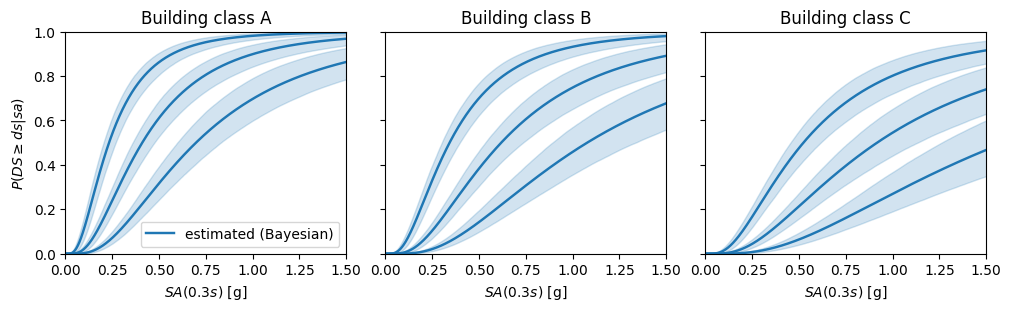

In [37]:
im = np.linspace(0.001,1.5,1000) # Horizontal axis

fig, axs = plt.subplots(1, 3, figsize=(10,3), sharey=True, constrained_layout=True)
for bc, ax in zip(args['list_bc'], axs):
    posterior.plot_frag_funcs(ax, bc=bc, im=im, color = 'tab:blue', 
                        kwargsm={'ls': '-', 'lw': 1.75, 'label': 'estimated (Bayesian)'})
    # true_params.plot_frag_funcs(ax, bc = bc, im = im, color = 'black',
    #                     kwargs={'ls': '-', 'label': 'true'})
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1.5])
    ax.set_xlabel('$SA(0.3s)$ [g]')
    ax.set_title('Building class ' + str(bc))
    if bc == args['list_bc'][0]:
        ax.set_ylabel('$P(DS \geq ds|sa)$')
        ax.legend()
plt.show()

In [22]:
# Store fragility function results
res_dir = os.getcwd() + os.sep + 'results' + os.sep + 'two_dim' + os.sep
filepath = (res_dir + 'Bayesian_frag_TwoDim_im_' + 
            args['im_string'] + '.nc')
posterior.save_as_netcdf(filepath = filepath, include_z = False)

### Posterior IM at survey sites

Below, we compare the prior and posterior IM distribution at the site of a surveyed building. 

The prior $p(im|\mathbf{im}_\mathcal{S}, \mathbf{rup})$ is a log-normal distribution.

Through the Bayesian approach, we obtain samples from the posterior $p(im|\mathbf{ds}, \mathbf{im}_\mathcal{S}, \mathbf{rup})$, which is additionally conditioned on the damage survey data.


Here, we fit a normal distribution to the log-transformed $im$ posterior samples.

In [133]:
# Site ID to plot
sid = 100

# Prior: Conditional on station data and rupture characteristics
muB_prior = mu_B_S[sid] # Mean of logIM
_, varB_prior = gpr.predict(survey_sites, full_cov=False)
sigmaB_prior = np.sqrt(varB_prior)[sid] # Std. dev. of logIM

# Posterior: Conditional on damage data, station data and rupture characteristics
samplesB_post = posterior.get_logIM_samples(mu_B_S, L_BB_S)[sid,:]
muB_post, sigmaB_post = stats.norm.fit(samplesB_post, method='MM')

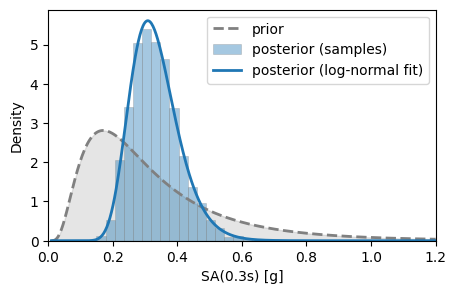

In [143]:
im_plot = np.linspace(0.01, 1.2, 500)

fig, ax = plt.subplots(figsize=(5,3))
# Prior
pdf = stats.lognorm.pdf(im_plot, s=sigmaB_prior, scale=np.exp(muB_prior))
ax.plot(im_plot, pdf, color='gray', lw=2, ls='--', label='prior')
ax.fill_between(im_plot, pdf, color='gray', alpha=0.2)
# Posterior
ax.hist(np.exp(samplesB_post), 20, density=True, color='tab:blue', alpha=0.4, 
    label='posterior (samples)', edgecolor='gray', lw=0.5)
pdf = stats.lognorm.pdf(im_plot, s=sigmaB_post, scale=np.exp(muB_post))
ax.plot(im_plot, pdf, color='tab:blue', lw=2, label='posterior (log-normal fit)')
ax.legend()
ax.set_xlim([0, 1.2])
ax.set_xlabel('SA(0.3s) [g]')
ax.set_ylabel('Density')
plt.show()

### Posterior predictive IM at new sites

Here, we compare the spatial distribution of prior and posterior IM values across a region of interest. For this purpose, we compute prior and posterior statistics for gridded sites that cover the region of interest. These sites are called target sites and we denote the corresponding IM values as $\mathbf{im}_\mathcal{T}$. Below, we first import the site information, in a similar way than for the survey and station sites before.

In [23]:
df = pd.read_csv(path_data + 'gridmap_im_' + args['im_string'] + 
                '_GMM_' + args['GMM'] + '.csv')
# Create sites
map_sites = Sites(
    coordinates = df[['Longitude', 'Latitude']].values,
    mu_logIM = df['mu_logIM'].values,
    tau_logIM = df['tau_logIM'].values,
    phi_logIM = df['phi_logIM'].values,
)
sh = (len(df.row.unique()), len(df.col.unique()))

Then, we compute the mean, 5% and 95% quantiles of the **prior** IM values at each target site. 
The prior is conditioned on station data and rupture characteristics, $p(\mathbf{im}_\mathcal{T}|\mathbf{im}_\mathcal{S}, \mathbf{rup})$.

In [144]:
# Mean and Variance (full_cov = False -> only diagonal of covariance matrix)
muT_prior, varT_prior = gpr.predict(map_sites, full_cov=False)

# Compute 5% and 95% quantiles and collect statistics
temp_fac = stats.norm.ppf(0.95) * np.sqrt(var_T_S)
logIMstats = np.append(mu_T_S[None,:],
          np.stack([mu_T_S + i for i in [-temp_fac, +temp_fac]]), 
          axis=0)
imT_prior = xr.DataArray(np.exp(logIMstats), dims = ['stat', 'sid'], 
                        coords = {'stat': ['median', 'q05', 'q95']})

Finally, we compute the mean, 5% and 95% quantiles of the **posterior** IM values at each target site. 
The posterior is conditioned on damage data, station data and rupture characteristics, $p(\mathbf{im}_\mathcal{T}|\mathbf{ds}, \mathbf{im}_\mathcal{S}, \mathbf{rup})$. Because the target sites are not identical to the building survey sites, we obtain this posterior predictive by marginalizing over the posterior IM values at the survey sites, $\mathbf{im}_\mathcal{B}$.

$p(\mathbf{im}_\mathcal{T}|\mathbf{ds}, \mathbf{im}_\mathcal{S}, \mathbf{rup}) = \int p(\mathbf{im}_\mathcal{T}|\mathbf{im}_\mathcal{B}, \mathbf{im}_\mathcal{S}, \mathbf{rup}) p(\mathbf{im}_\mathcal{B}|\mathbf{ds}, \mathbf{im}_\mathcal{S}, \mathbf{rup}) \, \mathrm{d}\mathbf{im}_\mathcal{B}$

The `PosteriorPredictiveIM` object performs this marginalization in a computationally efficient manner. 

In [160]:
from modules.results import PosteriorPredictiveIM
postpredIM = PosteriorPredictiveIM(GPR = gpr, survey_sites = survey_sites)

samplesT_post = postpredIM.sample(args['mcmc_seed'], map_sites, posterior.samples['z'].values, 
                            L_BB_S, full_cov = False)

# Compute mean and 5%, 95% quantiles
logIMstats = np.append(np.mean(samplesT_post, axis=0)[None,:],
          np.quantile(samplesT_post, [0.05, 0.95], axis=0), 
          axis=0)
imT_post = xr.DataArray(np.exp(logIMstats), dims = ['stat', 'sid'], 
                    coords = {'stat': ['median', 'q05', 'q95']})

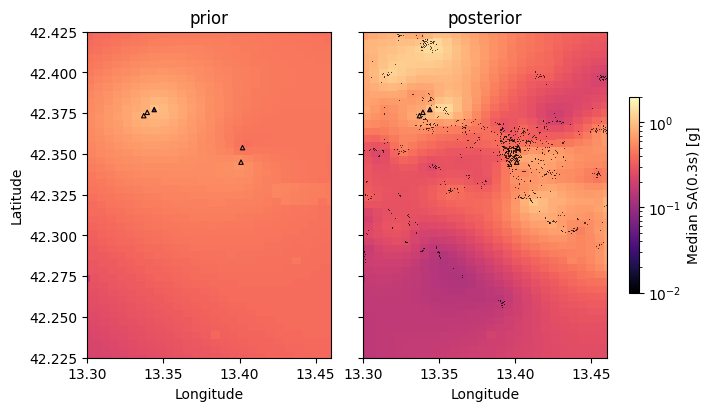

In [161]:
stat = 'median'

X = map_sites.coor[:, 0].reshape(sh)
Y = map_sites.coor[:, 1].reshape(sh)
norma = mpl.colors.LogNorm(vmin=0.01, vmax=2)
cmap = plt.get_cmap('magma')
fig, axs = plt.subplots(1, 2, figsize=(7,4), sharey=True,
                        constrained_layout=True)
vals = [imT_prior.loc[stat].values, imT_post.loc[stat].values]
titles = ['prior', 'posterior']
for i, ax in enumerate(axs):
    Z = vals[i].reshape(sh)
    im = ax.pcolormesh(X,Y,Z,  norm=norma, cmap=cmap)
    ax.scatter(station_sites.coor[:,0], station_sites.coor[:,1], c = obs_logIM,
                   marker='^', edgecolor='black', s=10, lw=0.8, norm = norma, cmap=cmap)
    if i == 1: 
        ax.scatter(survey_sites.coor[:,0], survey_sites.coor[:,1], 
                   marker='.', color='black', s=0.8, lw=0.2)
    ax.set_xlim([13.3, 13.46])
    ax.set_ylim([42.225, 42.425])
    ax.set_title(titles[i])
    if i == 0: ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    # ax.set_aspect('equal')
cbar = fig.colorbar(im, ax=axs[:], 
             orientation ='vertical', shrink=0.6, 
             label='Median SA(0.3s) [g]', pad=0.035,)
plt.show()

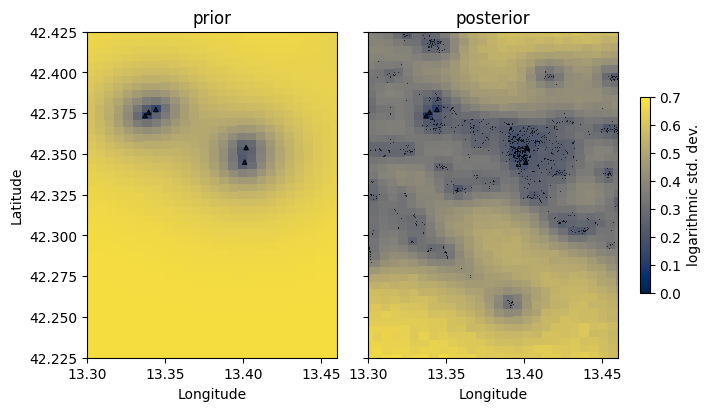

In [153]:
stat = 'median'

norma = mpl.colors.Normalize(vmin=0, vmax=0.7)
cmap = plt.get_cmap('cividis')
fig, axs = plt.subplots(1, 2, figsize=(7,4), sharey=True,
                        constrained_layout=True)
vals = [np.sqrt(var_T_S), np.std(samplesT_post, axis=0)]
titles = ['prior', 'posterior']
for i, ax in enumerate(axs):
    Z = vals[i].reshape(sh)
    im = ax.pcolormesh(X,Y,Z,  norm=norma, cmap=cmap)
    ax.scatter(station_sites.coor[:,0], station_sites.coor[:,1], c = obs_logIM,
                   marker='^', edgecolor='black', s=10, lw=0.8, norm = norma, cmap=cmap)
    if i == 1: 
        ax.scatter(survey_sites.coor[:,0], survey_sites.coor[:,1], 
                   marker='.', color='black', s=0.8, lw=0.2)
    ax.set_xlim([13.3, 13.46])
    ax.set_ylim([42.225, 42.425])
    ax.set_title(titles[i])
    if i == 0: ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    # ax.set_aspect('equal')
cbar = fig.colorbar(im, ax=axs[:], 
             orientation ='vertical', shrink=0.6, 
             label='logarithmic std. dev.', pad=0.035,)
plt.show()

In [149]:
# Store IM statistics for plotting
ds = xr.Dataset({'imT_prior': imT_prior, 'imT_post' : imT_post})
ds.attrs = posterior.samples.attrs
ds.to_netcdf(res_dir + 'IMresults_TwoDim_' + args['im_string'] + '.nc')

In [28]:
import numpyro.distributions as dist
from modules.inference import get_pmf_ds_logIM
init_values = dict()
for param in parampriors.keys():
  init_values[param] = parampriors[param].mean

def Model_fixedIM_mle(mu_logIM, ds, bc, init_values):
    # note that we need to include positive constraints;
    # in the MCMC model these constraints appear implicitly in
    # the support of the chosen prior distributions.

    N = ds.shape[0] # Number of data points

    eta1 = numpyro.param('eta1', init_value = init_values['eta1'])
    beta = numpyro.param('beta', init_value = init_values['beta'],
                          constraint = dist.constraints.positive)
    if 'deltas' in init_values.keys():
        deltas = numpyro.param('deltas', init_value = init_values['deltas'],
                        constraint = dist.constraints.positive)

    # Compute damage state probabilities: dim (n_sites, n_ds)
    p = get_pmf_ds_logIM(mu_logIM, bc, eta1, deltas, beta).T

    # Observations: dim (n_sites,)
    numpyro.sample('obs', dist.Categorical(probs = p), obs = ds)

def Guide_fixedIM_mle(mu_logIM, ds, bc, init_values):
  pass

In [29]:
from numpyro.infer import SVI, Trace_ELBO
optimizer = numpyro.optim.Minimize(method='BFGS')
mle = SVI(Model_fixedIM_mle, Guide_fixedIM_mle, optimizer, loss=Trace_ELBO())
mle_result = mle.run(jax.random.PRNGKey(5), 5000, mu_logIM = mu_B_S, 
                     ds = obs_DS, bc = obs_BC,
                     init_values = init_values)

100%|██████████| 5000/5000 [00:10<00:00, 481.39it/s, init loss: 3354.1813, avg. loss [4751-5000]: 3354.1813]


In [30]:
res_fixedIM = PointEstimates.from_dict(mle_result.params, args)

In [31]:
res_fixedIM.get_fragparams(option = 'thetas')

,beta,theta1,theta2,theta3
bc,,,,
A,0.846254,0.254124,0.429366,0.719594
B,0.909898,0.369979,0.681498,1.215884
C,0.951884,0.552116,0.986702,1.793546


In [32]:
true_params.get_fragparams(option = 'thetas')

,beta,theta1,theta2,theta3
bc,,,,
A,0.59,0.25,0.41,0.66
B,0.68,0.37,0.65,1.05
C,0.75,0.52,0.93,1.49


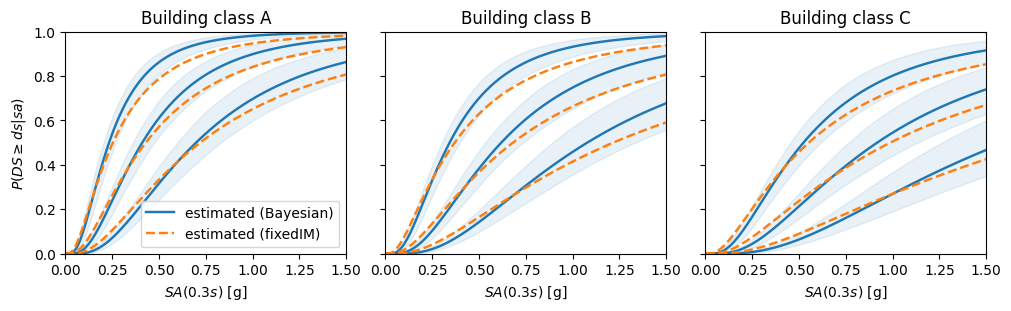

In [35]:
im = np.linspace(0.001,1.5,1000) # Horizontal axis

fig, axs = plt.subplots(1, 3, figsize=(10,3), sharey=True, constrained_layout=True)
for bc, ax in zip(args['list_bc'], axs):
    posterior.plot_frag_funcs(ax, bc=bc, im=im, color = 'tab:blue', 
                        kwargsm={'ls': '-', 'lw': 1.75, 'label': 'estimated (Bayesian)'},
                        kwargsCI={'alpha': 0.1})
    res_fixedIM.plot_frag_funcs(ax, bc=bc, im=im, color = 'tab:orange', 
                        kwargs={'ls': '--', 'lw': 1.75, 'label': 'estimated (fixedIM)'})
    # true_params.plot_frag_funcs(ax, bc = bc, im = im, color = 'black',
    #                     kwargs={'ls': '-', 'label': 'true'})
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1.5])
    ax.set_xlabel('$SA(0.3s)$ [g]')
    ax.set_title('Building class ' + str(bc))
    if bc == args['list_bc'][0]:
        ax.set_ylabel('$P(DS \geq ds|sa)$')
        ax.legend()
plt.show()